Numerically calculate the Fourier solution of GK system 

In [28]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from gk_solver.gk_apar0 import (dispersion, A, B, 
                                C, D, L, M,det_deriv)
from gk_solver.util import real_imag, list2complex
import seaborn as sns
%matplotlib inline

Residues
- Residues for slow and entropy mode 
$$\mathrm{Res}(p_i)\left[\frac{T_i}{q_i}\frac{u_{\mathbf{k}0}}{k_\parallel v_{ti}}\right]^{-1}$$
- for driving frequency $p_0$ or $\overline{\omega}_0$

In [149]:
def res_i(ti_te, mi_me, bi, kperp_rhoi, 
          wbar_0, wbar_i, tbar, turnoff=None):
    """
    Calculate Residue(p_i) or Residue(\overline{\omega}_i)
    """
    a = A(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    c = C(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    d = D(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    l = L(ti_te, mi_me, bi, wbar_i)
    m = M(ti_te, mi_me, bi, wbar_i)
    dmdw = det_deriv(ti_te, mi_me, bi, kperp_rhoi, wbar_i)
    
    numer = np.array([(d - 2/bi)*l - c*m,\
                      -c*l + a*m])
    denom = dmdw * (wbar_i - wbar_0)
    return numer / denom * np.exp(-1j * wbar_i * tbar)

In [150]:
def res_0(ti_te, mi_me, bi, kperp_rhoi, 
          wbar_0, tbar, turnoff=None):
    """
    Calculate Residue(p_0) or Residue(\overline{\omega}_0)
    """
    a = A(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    c = C(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    d = D(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    l = L(ti_te, mi_me, bi, wbar_0)
    m = M(ti_te, mi_me, bi, wbar_0)
    detm = dispersion(ti_te, mi_me, bi, kperp_rhoi, wbar_0)
    
    numer = np.array([(d - 2/bi)*l - c*m,\
                      -c*l + a*m])
    return numer / detm * np.exp(-1j * wbar_0 * tbar)

Helper function to find eigenmode frequencies

In [151]:
def eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi):
    """
    find the eigenmodes of the gk system.
    currently hard coded the initial values for beta_i << 1, Ti = Te.
    """
    # slow mode
    guess_sm_1 = np.sqrt(bi) * 1.4 * (1-0.5j)
    guess_sm_2 = np.sqrt(bi) * 1.4 * (-1-0.5j)
    # entropy mode
    guess_sm_3 = (-0.2 * np.log10(bi) -0.58) * 1j

    f = lambda w_bar: real_imag(dispersion(ti_te, mi_me, bi, kperp_rhoi, list2complex(w_bar)))
    wbar_arr = []
    for guess in [guess_sm_1, guess_sm_2, guess_sm_3]:
        res = scipy.optimize.fsolve(f, real_imag(guess))
        wbar = list2complex(res)
        if np.abs(wbar.real) < 1.e-10:
            wbar = 1j * wbar.imag
        wbar_arr += [wbar]
    return wbar_arr

Helper function to construct time series

In [152]:
def ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                   wbar_0, wbar_arr, tbar_arr, turnoff=None):
    """
    return time series for B_parallel and phi
    """
    
    def phi_b(tbar):
        """
            vector(\phi(t), B(t))
    """
        res = res_0(ti_te, mi_me, bi, kperp_rhoi, wbar_0, tbar, turnoff=turnoff)
        for wbar_i in wbar_arr:
            res += res_i(ti_te, mi_me, bi, kperp_rhoi, wbar_0, wbar_i, tbar, turnoff=turnoff)
        return res
    
    phi_b_arr = np.array([phi_b(tbar) for tbar in tbar_arr])
    return phi_b_arr

Parameter

In [153]:
ti_te = 1.
kperp_rhoi = 0.2
wbar_0 = 0.12
bi = 0.01
upar0 = 10
mi_me = 1836

texts = "{0}{1}\n".format(r'$\beta_i$=',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1}\n".format(r'$\overline{u}_0=$', upar0) +\
    "{0}{1:.2f}\n".format(r'$\overline{\omega}_0=$', wbar_0)

Eigenmodes / simple poles

In [154]:
wbar_arr = eigenmode_finder(ti_te, mi_me, bi, kperp_rhoi)
print(wbar_arr)
wbar_arr=wbar_arr[:2]
print(wbar_arr)

[(0.14394216347628239-0.064380505675528929j), (-0.14394216347628239-0.064380505675528943j), (-0-0.1851836105088204j)]
[(0.14394216347628239-0.064380505675528929j), (-0.14394216347628239-0.064380505675528943j)]


In [155]:
tbar_arr = np.linspace(0, 200, 1000)
phi_bpar_arr = ts_constructor(ti_te, mi_me, bi, kperp_rhoi, 
                              wbar_0, wbar_arr, tbar_arr)
phi_arr = np.abs(phi_bpar_arr[:, 0])
bpar_arr = np.abs(phi_bpar_arr[:,1])

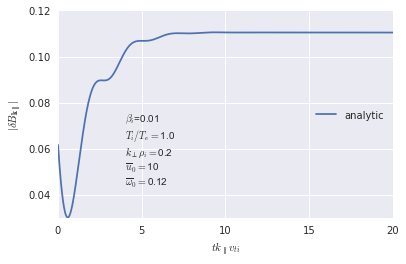

In [156]:
fig_bpar_temp = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr * np.sqrt(bi), bpar_arr * upar0, 
             label = 'analytic')
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

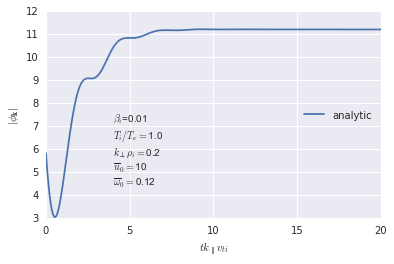

In [157]:
fig_phi_temp = plt.figure(figsize=[6, 6*0.618])
plt.plot(tbar_arr * np.sqrt(bi), phi_arr * upar0, label = 'analytic')
plt.legend(loc='center right')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
ax = plt.gca()
plt.text(0.2, 0.1, texts, transform=ax.transAxes,)
plt.show()

# AstroGK simulation

In [116]:
from gk_solver.util import dtype_bpar, dtype_phi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
data_dir = '/Volumes/yuguang_sd/data/agk/lin_response/upar_160929'
i = 1
filename_bpar = data_dir + '/lin_upar_{0:s}.bpar'.format(str(i))
filename_phi = data_dir + '/lin_upar_{0:s}.phi'.format(str(i))
data_bpar = np.loadtxt(filename_bpar, dtype = dtype_bpar)
data_phi = np.loadtxt(filename_phi, dtype = dtype_bpar)

In [118]:
def readColumn(data, column):
    return np.array([elem[column] for elem in data])

In [119]:
bpar = np.sqrt(readColumn(data_bpar, 3))
t_bpar = readColumn(data_bpar, 1)
phi = np.sqrt(readColumn(data_phi, 3))
t_phi = readColumn(data_phi, 1)

In [120]:
ti_te = 1.
kperp_rhoi = 0.2
wbar_0 = 0.14
bi = 0.01
upar0 = 10
mi_me = 1836

texts = "{0}{1}\n".format(r'$\beta_i$=',bi) + \
    "{0}{1}\n".format(r'$T_i/T_e=$',ti_te) + \
    "{0}{1}\n".format(r'$k_\perp \rho_i=$',kperp_rhoi) + \
    "{0}{1}\n".format(r'$\overline{u}_0=$', upar0) +\
    "{0}{1:.2f}\n".format(r'$\overline{\omega}_0=$', wbar_0)

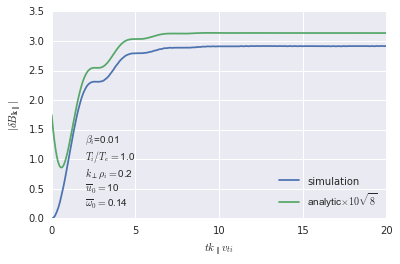

In [121]:
fig_bpar = plt.figure(figsize=[6, 6*0.618])
plt.plot(t_bpar, bpar * np.sqrt(8) * 10, label = 'simulation')
plt.plot(tbar_arr * np.sqrt(bi), 
         bpar_arr * upar0 * np.sqrt(8) * 10, 
         label = 'analytic' + r'$\times10\sqrt{8}$')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\delta B_{\mathbf{k}\parallel}|$')
plt.legend(loc='lower right')
ax = plt.gca()
plt.text(0.1, 0., texts, transform=ax.transAxes)

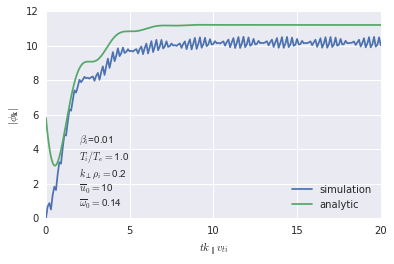

In [122]:
fig_phi = plt.figure(figsize=[6, 6*0.618])
plt.plot(t_phi, phi, label = 'simulation')
plt.plot(tbar_arr * np.sqrt(bi), phi_arr*upar0, label = 'analytic')
plt.xlabel('$tk_\parallel v_{ti}$')
plt.ylabel('$|\phi_{\mathbf{k}}|$')
plt.legend(loc='lower right')
ax = plt.gca()
plt.text(0.1, 0, texts, transform=ax.transAxes)